In [8]:
import os
import numpy as np
from datetime import datetime
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from utils import parse_anno_file, create_mask_file, big_image_predict, get_time, true_results

path = 'asbest/test_images_stones'
img_pathes = [os.path.join(path, it) for it in os.listdir(path) if it.endswith('bmp')]

In [2]:
import torch
from torch import nn
from torch import sigmoid
import segmentation_models_pytorch as smp


device = torch.device("cuda:" + str(torch.cuda.device_count() - 1) if torch.cuda.is_available() else "cpu")

model = smp.Unet(encoder_name='efficientnet-b3', encoder_weights='imagenet', in_channels=1, classes=2,  activation='sigmoid').to(device)

bce = smp.utils.losses.BCEWithLogitsLoss()
dice = smp.utils.losses.DiceLoss()



In [3]:
model.load_state_dict(torch.load('asbest_segmentation_b3_v1.2.pth'))

<All keys matched successfully>

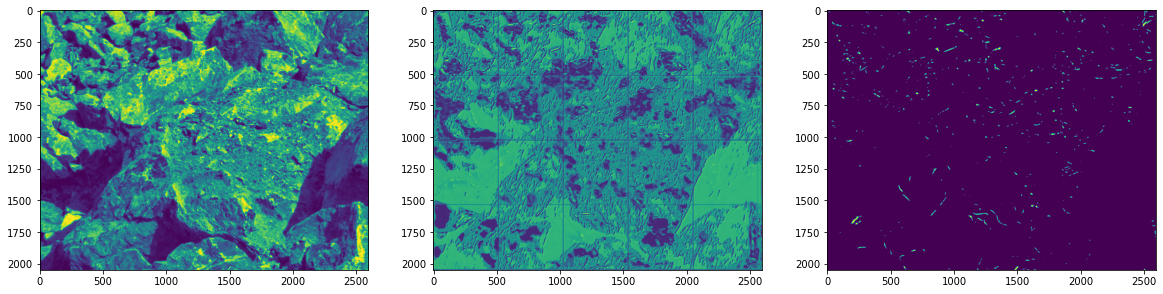

In [4]:
img = cv2.imread(img_pathes[0], cv2.IMREAD_UNCHANGED)
img, st, asb = big_image_predict(model, 
                                  img, 
                                  crop_size=(2*512,2*512),#(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                  inp_size=(2*512,2*512),
                                  device=device
                                 )
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(st)
plt.subplot(133)
plt.imshow(asb > 0.5)

In [10]:
asbest_content = {1 : [], 2: [], 3: []}
for img_path in tqdm(img_pathes, total=len(img_pathes)):
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    pit = int(img_path.split('/')[-1][0])
    S = img.shape[0] * img.shape[1]
    img, st, asb = big_image_predict(model, 
                                      img, 
                                      crop_size=(2*512,2*512),#(img_tr_stones_shape[0] // 2, img_tr_stones_shape[1] // 2),
                                      inp_size=(2*512,2*512),
                                      device=device
                                     )
    S_asb = len(np.where(asb > 0.5)[0])
    asbest_content[pit].append(S_asb / S)
    

In [12]:
for i in asbest_content.keys():
    print(str(i) + ' карьер -', 0.4 * np.mean(asbest_content[i]) * 100 + 1)

1 карьер - 1.1091091811713556
2 карьер - 1.2613958466587476
3 карьер - 1.3254906925154322


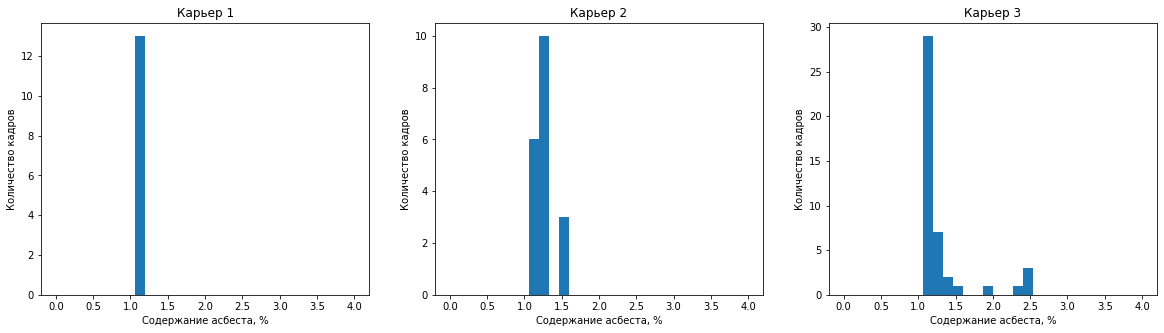

In [22]:
plt.figure(figsize=(20,5))
for i in asbest_content.keys():
    plt.subplot(1,3,i)
    plt.hist(0.4 * np.array(asbest_content[i]) * 100 + 1, bins=30, range=[0, 4]);
    plt.title('Карьер ' + str(i))
    plt.xlabel('Содержание асбеста, %')
    plt.ylabel('Количество кадров')
plt.savefig('result.png', dpi = 300, bbox_inches='tight', pad_inches=0)

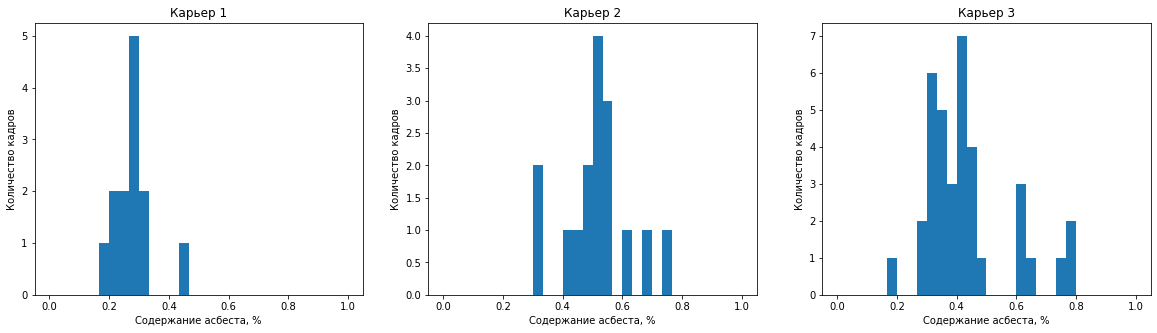

In [26]:
plt.figure(figsize=(20,5))
for i in asbest_content.keys():
    plt.subplot(1,3,i)
    plt.hist(np.array(asbest_content[i]) * 100, bins=30, range=[0, 1]);
    plt.title('Карьер ' + str(i))
    plt.xlabel('Содержание асбеста, %')
    plt.ylabel('Количество кадров')
plt.savefig('result.png', dpi = 300, bbox_inches='tight', pad_inches=0)

In [13]:
import csv
with open("first_results.csv", 'w') as csvfile:
    spamreader = csv.writer(csvfile, csv.QUOTE_ALL)
    spamreader.writerow(list(np.array(asbest_content) * 100))

In [24]:
import numpy as np
a = [i for i in range(10)]
np.random.choice(a, 10)

array([4, 8, 1, 9, 7, 3, 9, 4, 6, 3])

In [32]:
X = np.random.rand(150,2)
indexes = np.random.randint(0, len(X), 4)
X[indexes]

array([[0.44023412, 0.72948105],
       [0.6185983 , 0.59090326],
       [0.55620138, 0.07385602],
       [0.73892598, 0.21442807]])